# **Decision tree regression**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [2]:
class Node:
    def __init__(
        self,
        split_feature_index=None,
        split_treshhold=None,
        left_subtree=None,
        right_subtree=None,
        node_variance_reduction=None,
        leaf_node_value=None,
    ):
        """This class is simply a collection of data that the top of the decision tree should store."""

        self.split_feature_index = split_feature_index
        self.split_treshhold = split_treshhold
        self.left_subtree = left_subtree
        self.right_subtree = right_subtree
        self.node_variance_reduction = node_variance_reduction

        self.leaf_node_value = leaf_node_value

In [3]:
class Decision_tree_regression:
    def __init__(self, node_min_samples_quant=2, max_depth=2):
        """This is the model class for decision tree regression"""

        self._node_min_samples_quant = node_min_samples_quant
        self._max_depth = max_depth

        self._root = None

    def fit(self, X, Y):
        """This function we need for training the model on the training set"""

        dataset = np.concatenate((X, Y), axis=1, dtype=object)
        self._root = self._build_tree(dataset)

    def _build_tree(self, dataset, current_depth=0):
        """This function we need for building а deсision tree"""
        X = dataset[:, :-1]
        Y = dataset[:, -1]

        dataset_rows_quant, dataset_features_quant = X.shape

        if (
            dataset_rows_quant >= self._node_min_samples_quant
            and current_depth <= self._max_depth
        ):
            best_split_values = self._get_best_split(dataset, dataset_features_quant)

            if best_split_values["node_variance_reduction"] > 0:
                left_subtree = self._build_tree(
                    best_split_values["dataset_left_split"], current_depth + 1
                )
                right_subtree = self._build_tree(
                    best_split_values["dataset_right_split"], current_depth + 1
                )

                return Node(
                    best_split_values["split_feature_index"],
                    best_split_values["split_treshhold"],
                    left_subtree,
                    right_subtree,
                    best_split_values["node_variance_reduction"],
                )

        leaf_node_value = self._calculate_leaf_node_value(Y)

        return Node(leaf_node_value=leaf_node_value)

    def _get_best_split(self, dataset, dataset_features_quant):
        """This function finds and makes the best split"""

        max_variance_reduction = -float("inf")
        best_split_values = {}

        for current_split_feature_idx in range(dataset_features_quant):
            possible_treshholds = np.unique(dataset[:, current_split_feature_idx])

            for current_split_treshhold in possible_treshholds:
                dataset_left_split, dataset_right_split = self._make_split(
                    dataset, current_split_feature_idx, current_split_treshhold
                )

                if len(dataset_left_split) > 0 and len(dataset_right_split) > 0:
                    current_variance_reduction = self._calculate_variance_reduction(
                        dataset, dataset_left_split, dataset_right_split
                    )

                    if current_variance_reduction > max_variance_reduction:
                        best_split_values[
                            "split_feature_index"
                        ] = current_split_feature_idx
                        best_split_values["split_treshhold"] = current_split_treshhold
                        best_split_values["dataset_left_split"] = dataset_left_split
                        best_split_values["dataset_right_split"] = dataset_right_split
                        best_split_values[
                            "node_variance_reduction"
                        ] = current_variance_reduction
                        max_variance_reduction = current_variance_reduction

        return best_split_values

    def _make_split(
        self, dataset, dataset_split_feature_index, dataset_split_treshhold
    ):
        """This function produces the best sample split"""
        dataset_left_split = np.array(
            [
                row
                for row in dataset
                if row[dataset_split_feature_index] <= dataset_split_treshhold
            ]
        )
        dataset_right_split = np.array(
            [
                row
                for row in dataset
                if row[dataset_split_feature_index] > dataset_split_treshhold
            ]
        )

        return dataset_left_split, dataset_right_split

    def _calculate_variance_reduction(
        self, dataset, dataset_left_split, dataset_right_split
    ):
        """This function calculates the reduction between the variance of the parent
        node and the sum of the variances of the child nodes"""

        dataset_targets = dataset[:, -1]
        dataset_left_split_targets = dataset_left_split[:, -1]
        dataset_right_split_targets = dataset_right_split[:, -1]

        card_dataset_left_split = len(dataset_left_split)
        card_dataset_right_split = len(dataset_right_split)
        card_dataset = len(dataset_targets)

        dataset_left_split_targets_variance = np.var(dataset_left_split_targets)
        dataset_right_split_targets_variance = np.var(dataset_right_split_targets)
        dataset_targets_variance = np.var(dataset_targets)

        dataset_variance = card_dataset * dataset_targets_variance
        split_variance = (
            card_dataset_left_split * dataset_left_split_targets_variance
            + card_dataset_right_split * dataset_right_split_targets_variance
        )

        variance_reduction = dataset_variance - split_variance

        return variance_reduction

    def _calculate_leaf_node_value(self, dataset_targets):
        """This function calculates the value that will be contained in the node if it is a leaf"""

        return np.mean(dataset_targets)

    def predict(self, data):
        """This function predicts the values for the sample that was passed as an argument"""

        predictions = np.array(
            [self._make_prediction(data_sample, self._root) for data_sample in data]
        )

        return predictions

    def _make_prediction(self, sample, current_node):
        """This function predicts a value for a particular sample object"""

        if current_node.leaf_node_value != None:
            return current_node.leaf_node_value
        else:
            feature_value = sample[current_node.split_feature_index]

            if feature_value <= current_node.split_treshhold:
                return self._make_prediction(sample, current_node.left_subtree)
            else:
                return self._make_prediction(sample, current_node.right_subtree)

In [4]:
df = pd.read_csv(
    "D://ADMP_Anastasia/machine_learning/datasets/dataset_for_decision_tree_regression.csv"
)
df

,x,x**3,x**5,x**7,y
0,-2.074295,-8.925074,-3.840193e+01,-1.652321e+02,-3.768735
1,2.359096,13.129152,7.306810e+01,4.066483e+02,3.923851
2,2.820229,22.431223,1.784110e+02,1.419026e+03,2.512261
3,-0.035897,-0.000046,-5.960887e-08,-7.681310e-11,-0.000046
4,-0.791447,-0.495754,-3.105348e-01,-1.945155e-01,-0.445595
...,...,...,...,...,...
295,-2.650994,-18.630574,-1.309314e+02,-9.201555e+02,-3.311162
296,-2.554505,-16.669404,-1.087761e+02,-7.098178e+02,-3.614725
297,-2.871734,-23.682768,-1.953083e+02,-1.610679e+03,-2.198575
298,-2.158768,-10.060459,-4.688454e+01,-2.184950e+02,-3.877667


In [5]:
X = df.iloc[:, :-1].values
Y = df.iloc[:, -1].values.reshape(-1, 1)

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=1 / 3, random_state=42
)

X_test_len = len(X_test)
Y_test_len = len(Y_test)

In [7]:
model = Decision_tree_regression(node_min_samples_quant=2, max_depth=5)
model.fit(X_train, Y_train)

In [8]:
Y_pred = model.predict(X_test)
Y_pred = Y_pred.reshape(-1, 1)
Y_pred_len = len(Y_pred)

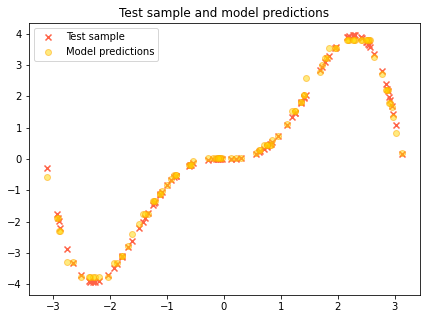

In [9]:
graph_X_values = X_test[:, 0]
graph_Y_test_values = Y_test
grapg_Y_pred_values = Y_pred

figure, ax = plt.subplots()

figure.set_figwidth(7)
figure.set_figheight(5)

ax.set_title("Test sample and model predictions")

ax.scatter(
    graph_X_values, graph_Y_test_values, color="tomato", label="Test sample", marker="x"
)
ax.scatter(
    graph_X_values,
    grapg_Y_pred_values,
    color="gold",
    edgecolors="orange",
    label="Model predictions",
    alpha=0.5,
)

ax.legend()

plt.show()

In [10]:
mean_squared_error_value = mean_squared_error(Y_test, Y_pred)
mean_squared_error_value

0.015587210904020356

In [11]:
test_df = pd.DataFrame(
    np.concatenate((X_test, Y_test), axis=1), columns=["x", "x**3", "x**5", "x**7", "y"]
)
test_df.head()

,x,x**3,x**5,x**7,y
0,-2.918149,-24.849758,-211.610369,-1801.987284,-1.886965
1,-3.112051,-30.139792,-291.899774,-2827.009467,-0.286062
2,2.194387,10.566701,50.882178,245.014604,3.909025
3,-2.355538,-13.069849,-72.518855,-402.375298,-3.925998
4,-2.265922,-11.634161,-59.734480,-306.700953,-3.943084


In [12]:
pred_df = pd.DataFrame(
    np.concatenate((X_test, Y_pred), axis=1), columns=["x", "x**3", "x**5", "x**7", "y"]
)
pred_df.head()

,x,x**3,x**5,x**7,y
0,-2.918149,-24.849758,-211.610369,-1801.987284,-1.896429
1,-3.112051,-30.139792,-291.899774,-2827.009467,-0.571750
2,2.194387,10.566701,50.882178,245.014604,3.807472
3,-2.355538,-13.069849,-72.518855,-402.375298,-3.775563
4,-2.265922,-11.634161,-59.734480,-306.700953,-3.775563
